In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

Let's prepare our Data 

In [137]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

# print(test_df.head(10))
# print(train_df.head(10))

if 'SalePrice' not in test_df.columns:
    test_df['SalePrice'] = 0 

housing_df = pd.concat([train_df,test_df], axis = 0)
housing_df = housing_df.set_index('Id')
print(housing_df.head(10))



    MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   
6           50       RL         85.0    14115   Pave   NaN      IR1   
7           20       RL         75.0    10084   Pave   NaN      Reg   
8           60       RL          NaN    10382   Pave   NaN      IR1   
9           50       RM         51.0     6120   Pave   NaN      Reg   
10         190       RL         50.0     7420   Pave   NaN      Reg   

   LandContour Utilities LotConfig  ... PoolArea PoolQC  Fence MiscFeature  \
Id                                  ...                              

In [138]:
df_null  = housing_df[housing_df.isnull().sum()[housing_df.isnull().sum()>0].index]


<Axes: ylabel='Id'>

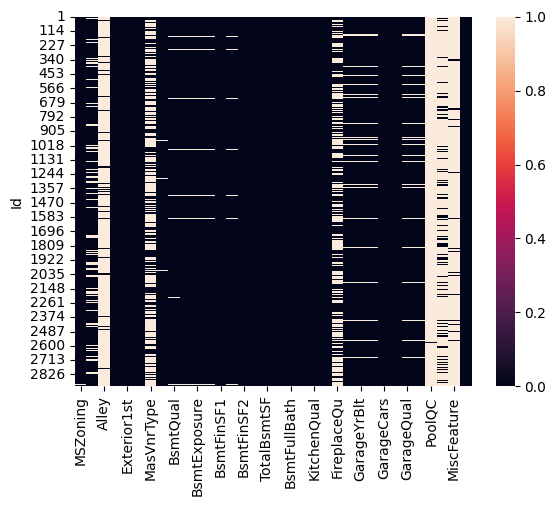

In [139]:
sns.heatmap(df_null.isnull())


In [140]:
df_objects =  housing_df[housing_df.select_dtypes(include=['object']).columns]
housing_df = housing_df.drop(housing_df[df_objects.isna().sum()[df_objects.isna().sum() > 1100].index], axis = 1)

In [141]:
df_objects = df_objects.drop(df_objects[df_objects.isna().sum()[df_objects.isna().sum() > 1100].index], axis = 1)

df_objects = df_objects.fillna('null')

df_objects_encoded = pd.get_dummies(df_objects)



In [142]:
df_objects['Utilities'].value_counts()

Utilities
AllPub    2916
null         2
NoSeWa       1
Name: count, dtype: int64

In [148]:
new_housing_df = pd.concat([housing_df, df_objects_encoded], axis = 1)
print(new_housing_df.head(10))

    MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
Id                                                                          
1           60       RL         65.0     8450   Pave      Reg         Lvl   
2           20       RL         80.0     9600   Pave      Reg         Lvl   
3           60       RL         68.0    11250   Pave      IR1         Lvl   
4           70       RL         60.0     9550   Pave      IR1         Lvl   
5           60       RL         84.0    14260   Pave      IR1         Lvl   
6           50       RL         85.0    14115   Pave      IR1         Lvl   
7           20       RL         75.0    10084   Pave      Reg         Lvl   
8           60       RL          NaN    10382   Pave      IR1         Lvl   
9           50       RM         51.0     6120   Pave      Reg         Lvl   
10         190       RL         50.0     7420   Pave      Reg         Lvl   

   Utilities LotConfig LandSlope  ... SaleType_New SaleType_Oth SaleType_WD

In [149]:
new_housing_df = new_housing_df.drop(housing_df.select_dtypes(include=['object']), axis = 1)

new_housing_df.isna().sum()[new_housing_df.isna().sum() > 0]

LotFrontage     486
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt     159
GarageCars        1
GarageArea        1
dtype: int64

In [150]:
Mode_columns = ['GarageCars', 'GarageYrBlt', 'BsmtFullBath', 'BsmtHalfBath']
Mean_columns = ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                'TotalBsmtSF', 'GarageArea']

for i in Mode_columns:
    new_housing_df[i] = new_housing_df[i].fillna(new_housing_df[i].mode()[0])

for i in Mean_columns:
    new_housing_df[i] = new_housing_df[i].fillna(np.round(new_housing_df[i].mean()))

new_housing_df.isna().sum()[new_housing_df.isna().sum() > 0] 

Series([], dtype: int64)

In [151]:
training_data = new_housing_df[0:len(train_df)]
testing_data = new_housing_df[len(test_df):]
testing_data = testing_data.drop(columns='SalePrice')

Now Let's train our data.

We are going to test out three models:
 * LinearRegression()
 * XGBRegressor()
 * RandomForestRegressor() 

In [152]:
X = training_data.drop(columns='SalePrice')
y = training_data['SalePrice']
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.2)

Y_test = np.reshape(Y_test,(-1,1))
Y_train = np.reshape(Y_train,(-1,1))

X_train.shape, Y_train.shape



((1168, 283), (1168, 1))

In [153]:
model_1 = LinearRegression()
model_1.fit(X, y)
y_pred = model_1.predict(X_test)
root_mean_squared_error(Y_test, y_pred)

np.float64(22426.003257318116)

In [154]:
model_2 = XGBRegressor(n_estimators=1000, learning_rate=0.1, random_state=42)
model_2.fit(X, y)
y_pred = model_2.predict(X_test)
MSE = (root_mean_squared_error(Y_test, y_pred))**2
print(MSE)


3657.6290927521163


In [155]:
model_3 = RandomForestRegressor(n_estimators=1000)
model_3.fit(X, y)
y_pred = model_3.predict(X_test)
root_mean_squared_error(Y_test, y_pred)

np.float64(11474.693716031677)

Based on the root_mean_squared_error of 2.796512201403204e-20 we can see that XGBRegressor is the most suitable and so we wil go with it

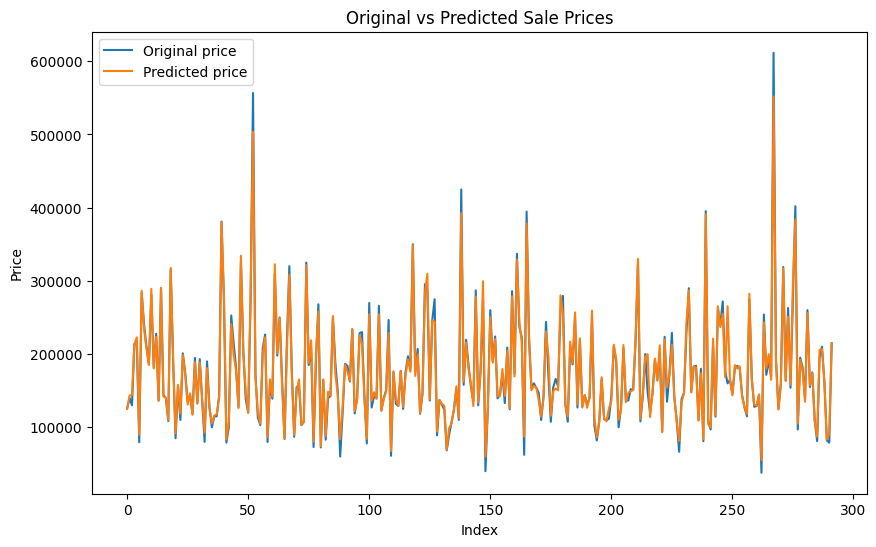

In [156]:
sort_indices = np.argsort(Y_test)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(Y_test)), Y_test, label='Original price')
plt.plot(np.arange(len(Y_test)), y_pred, label='Predicted price')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Original vs Predicted Sale Prices')
plt.legend()
plt.show()

In [159]:
pred = model_2.predict(testing_data)

final = pd.DataFrame()
final['Id'] = testing_data.index
final['SalePrice'] = pred

df = pd.read_csv("output.csv")

# Remove the last two rows
df = df.iloc[:-2]


# Write DataFrame to a CSV file without index
df.to_csv('output.csv', index=False)